In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent)

('2017-08-23',)


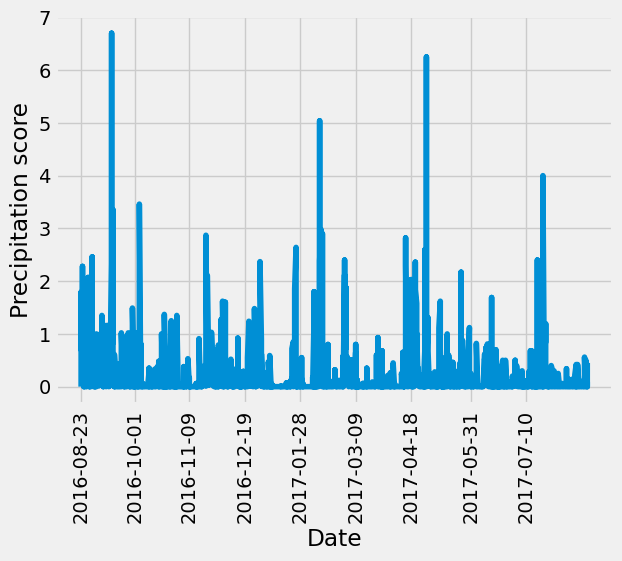

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = dt.datetime.strptime(recent[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
last_year= dt.date(last_date.year - 1, last_date.month, last_date.day)

# Perform a query to retrieve the data and precipitation scores
last_year_query = session.query(measurement.date, measurement.prcp).\
    order_by(measurement.date.asc()).\
        filter(measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_last_year = pd.DataFrame(last_year_query)

# Sort the dataframe by date
df_last_year = df_last_year.sort_values(by=['date'], ascending=True)
df_last_year = df_last_year.dropna()

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(df_last_year.date, df_last_year.prcp)
#ticks as shown in the requirements page
plt.xticks(['2016-08-23','2016-10-01','2016-11-09','2016-12-19','2017-01-28','2017-03-09','2017-04-18','2017-05-31','2017-07-10'], rotation = 90)
plt.xlabel("Date")
plt.ylabel("Precipitation score")
plt.savefig('precipitation.png')


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_last_year.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(station.id).count()

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement.station, func.count(measurement.id)]
active_stations = session.query(*sel).\
    group_by(measurement.station).\
        order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
most_active = session.query(*sel).\
    group_by(measurement.station).\
        order_by(func.count(measurement.id).desc()).first()
most_active

(54.0, 85.0, 71.66378066378067)

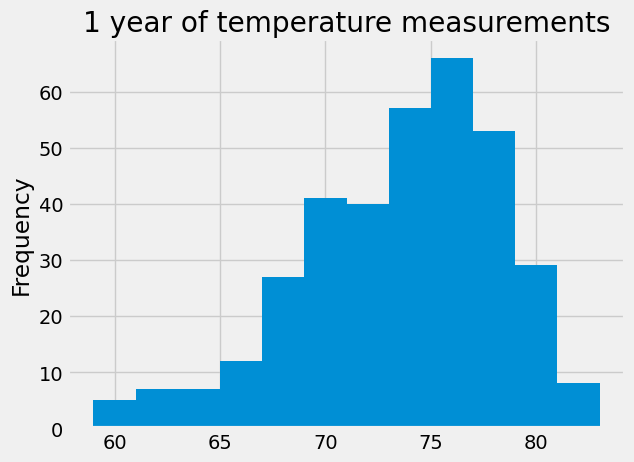

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(measurement.date, measurement.tobs).order_by(measurement.date.desc()).filter(measurement.station==active_stations[0][0]).filter(measurement.date >= last_year).all()
temp_list = list(query)
df_temps = pd.DataFrame(temp_list)

#create a plot. create 12 bins as outlined in requirements
plt.hist(df_temps['tobs'], bins=12)
plt.ylabel('Frequency')
plt.title("1 year of temperature measurements")
plt.savefig('temperature.png')

# Close Session

In [16]:
# Close Session
session.close()